## Librerías y funciones

Lo primero es cargar las librerías y funciones genéricas necesarias.

In [ ]:
import pandas as pd
import numpy as np
import re
import unicodedata
import string
from string import punctuation
import ast
from collections import Counter
import nltk
nltk.download('wordnet')

seed = 17

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas
import random


import string
import unicodedata
from stop_words import get_stop_words
from nltk.corpus import stopwords

from nltk import ngrams
from nltk.probability import FreqDist

from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('averaged_perceptron_tagger')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_recall_curve,make_scorer, recall_score, accuracy_score, precision_score

import gzip
import pickle
from textstat.textstat import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1. Carga de datos

Cargamos los ficheros comprimidos ya con los datos de train/val pre-procesados siguiendo el razonamiento del notebook anterior. En esta ocasión, se han almacenado los datos relativos a los textos preprocesados con su clasificación correspondiente. 




In [ ]:
train = pd.read_pickle('./train.pkl.gz')
val = pd.read_pickle('./val.pkl.gz')

In [ ]:
train.shape

(18834, 7001)

In [ ]:
val.shape

(4709, 7001)

## 2. TF-IDF Corpus


A continuación, vamos a ejemplificar el modelo de clasificación de sentimiento de un texto (dado nuestro corpus) mediante las técnicas de *Bag of Words*.  ¿En qué consiste? Construir un vocabulario a partir de un corpus de documentos y cuenta cuántas veces aparecen las palabras en cada documento. Dicho de otra manera, cada palabra del vocabulario se convierte en una característica y un documento se representa mediante un vector con la misma longitud del vocabulario (una “bolsa de palabras”).

La frecuencia de los términos no es necesariamente la mejor representación del texto. De hecho, puede encontrar en el corpus palabras comunes con la mayor frecuencia pero con poco poder predictivo sobre la variable objetivo. Para abordar este problema, existe una variante avanzada de Bag-of-Words que, en lugar de un simple conteo, usa el término frecuencia-frecuencia inversa del documento (o Tf-Idf). Básicamente, el valor de una palabra aumenta proporcionalmente a la cuenta, pero es inversamente proporcional a la frecuencia de la palabra en el corpus. Tal y como hemos visto en clase del módulo de DL y NLP.


Cabe recordar que en el notebook anterior, se han guardado los datos que se emplearán en este caso. Nuestro objetivo es mostrar que considerando el mismo algoritmo si vamos aumentando la información proporcionada a ver cómo evoluciona el *performance* del algoritmo. 

Para ello, nos hemos basado principalmente en el paper de referencia del proyecto.


In [ ]:
# Separación en conjunto de train y test
X_train = train.drop('class_tweet',axis=1)
y_train = train[['class_tweet']]

X_val = val.drop('class_tweet',axis=1)
y_val = val[['class_tweet']]

In [ ]:
lr = LogisticRegression(C=100, solver='lbfgs', max_iter=500, class_weight='balanced')
lr.fit(X_train, y_train)
test_predict = lr.predict(X_val)

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_val, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_val, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_val, test_predict)))

Confussion matrix:
[[ 100  139   33]
 [ 257 3235  154]
 [  27   97  667]]

Classification report:
              precision    recall  f1-score   support

           0       0.26      0.37      0.30       272
           1       0.93      0.89      0.91      3646
           2       0.78      0.84      0.81       791

    accuracy                           0.85      4709
   macro avg       0.66      0.70      0.67      4709
weighted avg       0.87      0.85      0.86      4709

Accuracy score:0.8498619664472287


## 3. TF-IDF  + TF-IDF del Postagger 

Ahora añadimos al paso anterior la información del TF-Idf del Postagger ya que según las bibliografías consultadas la sintaxis puede ayudar a la hora de realizar la clasificación.

In [ ]:
train = pd.read_pickle('./train_pos.pkl.gz')
val = pd.read_pickle('./val_pos.pkl.gz')

train.shape

val.shape

# Separación en conjunto de train y test
X_train = train.drop('class_tweet',axis=1)
y_train = train[['class_tweet']]

X_val = val.drop('class_tweet',axis=1)
y_val = val[['class_tweet']]

lr = LogisticRegression(C=100, solver='lbfgs', max_iter=500, class_weight='balanced')
lr.fit(X_train, y_train)
test_predict = lr.predict(X_val)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_val, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_val, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_val, test_predict)))

Confussion matrix:
[[  92  144   36]
 [ 235 3264  147]
 [  25  108  658]]

Classification report:
              precision    recall  f1-score   support

           0       0.26      0.34      0.29       272
           1       0.93      0.90      0.91      3646
           2       0.78      0.83      0.81       791

    accuracy                           0.85      4709
   macro avg       0.66      0.69      0.67      4709
weighted avg       0.87      0.85      0.86      4709

Accuracy score:0.8524102781906987


## 4. TF-IDF  + TF-IDF del Postagger + Features del Corpus

Finalmente, añadimos también ciertas dimesiones calculadas sobre los textos para enriquecer los datos.

In [ ]:
train = pd.read_pickle('./train_proc.pkl.gz')
val = pd.read_pickle('./val_proc.pkl.gz')

# Separación en conjunto de train y test
X_train = train.drop('class_tweet',axis=1)
y_train = train[['class_tweet']]

X_val = val.drop('class_tweet',axis=1)
y_val = val[['class_tweet']]

lr = LogisticRegression(C=100, solver='lbfgs', max_iter=500, class_weight='balanced')
lr.fit(X_train, y_train)
test_predict = lr.predict(X_val)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_val, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_val, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_val, test_predict)))

Confussion matrix:
[[ 146   70   56]
 [ 522 2579  545]
 [ 107   72  612]]

Classification report:
              precision    recall  f1-score   support

           0       0.19      0.54      0.28       272
           1       0.95      0.71      0.81      3646
           2       0.50      0.77      0.61       791

    accuracy                           0.71      4709
   macro avg       0.55      0.67      0.57      4709
weighted avg       0.83      0.71      0.75      4709

Accuracy score:0.7086430239966023


Llegados a este punto, se puede ver rápidamente que las prestaciones de los modelos van empeorando a medida que vamos añadiendo más dimensiones. Como ya comentamos en la parte exploratoria del dataset, no hay ninguna característica que *a priori* marque una diferencia siggnificativa entre clases del sentimiento. Por ello, al incorporarlas al conjunto de datos de entrenamiento, tan sólo se está añadiendo un poco de ruido al modelo. 


Cabe comentar que se han probado otros modelos como RandomForest, entre otros. Además, se ha probado con la libreria pycaret que va probando varios modelos y compara los valores obtenidos. 


## 5. Tratamiento del desbalanceo de clases

Como se ha observado el hecho de tener un dataset desbalanceado está produciendo bajas prestaciones en los modelos. Los modelos probados en general son buenos prediciendo la clase mayoritaria (class = 1) y malos prediciendo las minoriatarias (class = 0 y class = 2)

In [ ]:
!pip install scikit-plot

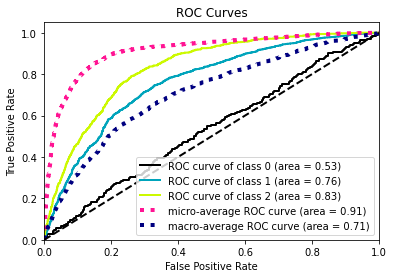

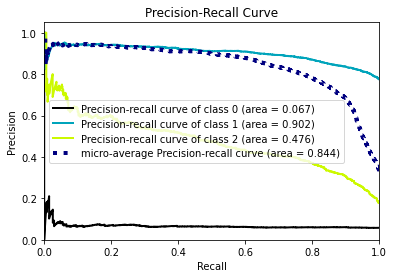

In [ ]:
# Building the imbalanced model

from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

model = LogisticRegression()
model.fit(X_train, y_train)

y_score = model.predict_proba(X_val)
y_pred = model.predict(X_val)

# Plot metrics 
plot_roc(y_val, y_score)
plt.show()
    
plot_precision_recall(y_val, y_score)
plt.show()

In [ ]:
#Pipeline undersampling and oversampling

count = y_train.value_counts()
n_samples = int(count.median())

import warnings
warnings.filterwarnings('ignore')

# Función que recibe el dataset, el threshold (n_samples) y las clases ('majority', 'minority')
def sampling_strategy(X,y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True] #.index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
# Undersampling de la clase mayoritaria
from imblearn.under_sampling import ClusterCentroids

under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train,y_train,n_samples,t='majority'))
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

In [ ]:
# Oversampling de la clase(s) minoritaria(s)
from imblearn.over_sampling import SMOTE

over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under,n_samples, t='minority'),k_neighbors=2)
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

In [ ]:
# Entrenamiento con el nuevo dataset balanceado

model = LogisticRegression()
model.fit(X_bal, y_bal)
y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)
# Plot metrics 
plot_roc(y_test, y_score)
plt.show()
    
plot_precision_recall(y_test, y_score)
plt.show()

Otro enfoque, el que llevaremos a cabo en el resto de implementaciones, es especificar pesos a las clases en la definición del modelo. Esto permite dar más importancia a las clases minoritarias y así dar solución a la problemática de clasificación de las clases minoritarias.

In [ ]:
# Función class_weight() de sklearn.utils library
from sklearn.utils import class_weight

classes = np.unique(y_train)
cw = class_weight.compute_class_weight('balanced', classes, y = np.ravel(y_train))
weights = dict(zip(classes,cw))

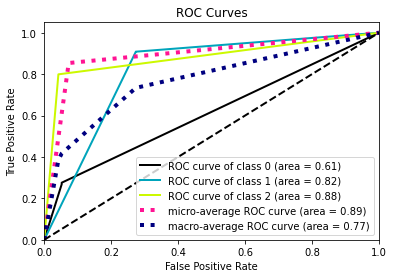

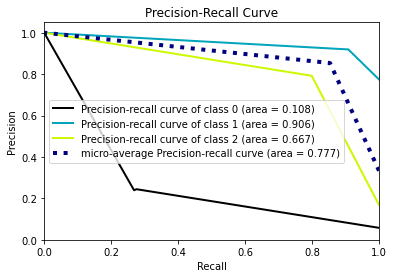

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight=weights)
model.fit(X_train, y_train)
y_score = model.predict_proba(X_val)
y_pred = model.predict(X_val)
# Plot metrics 
plot_roc(y_val, y_score)
plt.show()
    
plot_precision_recall(y_val, y_score)
plt.show()